# Sprint20 セグメンテーション2

## Model architecture tuning & score optimization


Some ideas and code taken from ealier [kernel](https://www.kaggle.com/wrosinski/clean-workflow-in-keras) and last prepared notebook.

Having dealt with data processing & engineering of channel features, next step of modeling is preparation and tuning of model architecture. Earlier notebooks provided a way to create images with three channels, which will facilitate usage of pretrained models.

For segmentation tasks, a pretrained model can be used as encoder part of the final architecture. 
In order to use pretrained models, we will have to extract features from a few intermediate layers, which will then serve as a basis for layers coming afterwards and for skip connections between encoder and decoder part.

ResNet50 is a good starting point, because it consists of 4 blocks, where each one of them can serve as feature extractor with first layer serving as the 5th extractor to achieve consistency with standard UNet architecture.

In [2]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 33kB/s 
     |████████████████████████████████| 3.8MB 18.6MB/s 
     |████████████████████████████████| 512kB 33.7MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=b8f7fe47631342dd89de5c1bf56e3784bf71e04f81e1b87ec8817c57e9e00acf
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [1]:
import tensorflow
tensorflow.__version__

'1.15.0'

In [2]:
# 自分のマイドライブにマウントする

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import gc
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from tqdm import tqdm

from keras import optimizers
from keras.callbacks import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import *
from keras.models import Model, load_model, save_model
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.resnet50 import ResNet50, preprocess_input

%matplotlib inline

Using TensorFlow backend.


In [4]:
plt.rcParams['figure.figsize'] = (12, 9)
# plt.style.use('ggplot')

In [5]:
def compute_coverage(df, masks):
    
    df = df.copy()
    
    def cov_to_class(val):
        for i in range(0, 11):
            if val * 10 <= i:
                return i

    # Output percentage of area covered by class
    df['coverage'] = np.mean(masks, axis=(1, 2))
    # Coverage must be split into bins, otherwise stratified split will not be possible,
    # because each coverage will occur only once.
    df['coverage_class'] = df.coverage.map(
        cov_to_class)

    return df


def create_depth_abs_channels(image_tensor):
    image_tensor = image_tensor.astype(np.float32)
    h, w, c = image_tensor.shape
    for row, const in enumerate(np.linspace(0, 1, h)):
        image_tensor[row, :, 1] = const
    image_tensor[:, :, 2] = (
        image_tensor[:, :, 0] * image_tensor[:, :, 1])

    x_dx = np.diff(image_tensor[:, :, 0], axis=0)
    x_dy = np.diff(image_tensor[:, :, 0], axis=1)
    x_dx = cv2.copyMakeBorder(x_dx, 1, 0, 0, 0, cv2.BORDER_CONSTANT, 0)
    x_dy = cv2.copyMakeBorder(x_dy, 0, 0, 1, 0, cv2.BORDER_CONSTANT, 0)
    image_tensor[:, :, 1] = np.abs(x_dx + x_dy)

    return image_tensor

### Data loading & depth merge:  
データロード

In [6]:
train = pd.read_csv('/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train.csv')
test = pd.read_csv('/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/sample_submission.csv')
depth = pd.read_csv('/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/depths.csv')

train_src = '/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train/'

print('train:\n{}'.format(train.head()))
print('\ntest:\n{}'.format(test.head()))


train = train.merge(depth, how='left', on='id')
test = test.merge(depth, how='left', on='id')

print('\n{}'.format(train.head()))

train:
           id                                           rle_mask
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...
1  3cb59a4fdc                                             1 5656
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...
3  c78c89577c                                              101 1
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...

test:
           id rle_mask
0  3e06571ef3      1 1
1  a51b08d882      1 1
2  c32590b06f      1 1
3  15f7a047c7      1 1
4  e8827bc832      1 1

           id                                           rle_mask    z
0  2c45b152f1  99 3 197 6 295 9 395 10 494 12 594 13 694 14 7...  312
1  3cb59a4fdc                                             1 5656  603
2  e185ab5dc1  4647 2 4748 10 4849 18 4950 25 5051 29 5152 34...  687
3  c78c89577c                                              101 1  236
4  6306dd3a8e  1 30 102 29 203 29 304 28 405 27 506 27 607 26...  805


In [ ]:
cd ..

/content


In [ ]:
ls

data/  drive/  sample_data/


### Load images and masks, examine random sample:

In [7]:
cd "/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train"

/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train


イメージ(訓練)/マスク（正解）読込

In [10]:
X_train = np.asarray(
    [cv2.imread('/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train/images/{}.png'.format(x), 0) for x in train.id.tolist()], 
    dtype=np.uint8) / 255.
y_train = np.asarray(
    [cv2.imread('/content/drive/My Drive/DIC/Segmantation/TGS_Salt_Identification_Challenge/competition_data/train/masks/{}.png'.format(x), 0) for x in train.id.tolist()],
    dtype=np.uint8) / 255.

print(X_train.shape, y_train.shape)

(4000, 101, 101) (4000, 101, 101)


In [12]:
# 画像のロードにかなりの時間がかかるので、読込済みのデータを保存しておく。
import pickle
with open('/content/drive/My Drive/DIC/Segmantation/X_train.pkl', 'wb') as xtrain:
    pickle.dump(X_train, xtrain)

with open('/content/drive/My Drive/DIC/Segmantation/y_train.pkl', 'wb') as ytrain:
    pickle.dump(y_train, ytrain)

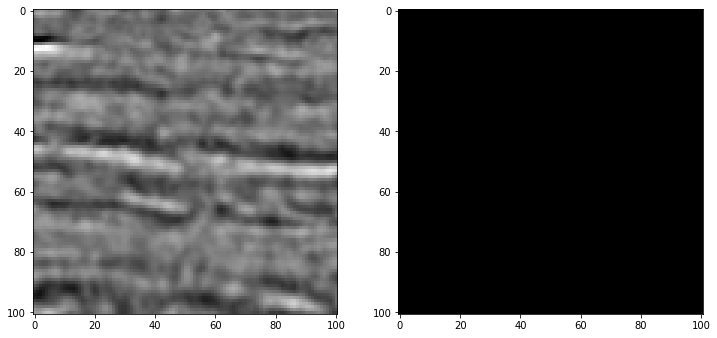

In [13]:
# ランダム抽出
random_index = np.random.randint(0, X_train.shape[0])

fig, ax = plt.subplots(1, 2)

# グレースケールで表示
ax[0].imshow(X_train[random_index], cmap='gray')
ax[1].imshow(y_train[random_index], cmap='gray')

### Compute salt coverage (this will serve as a basis for stratified split):  
塩分含有率の計算

In [14]:
train = compute_coverage(train, y_train)

### Prepare data for training:
前処理

In [15]:
kfold = StratifiedKFold(n_splits=5, random_state=1337)

# Add channel features
X_train_ch = np.repeat(np.expand_dims(X_train, axis=-1), 3, -1)
X_train_ch = np.asarray(list(map(lambda x: create_depth_abs_channels(x), X_train_ch)))

# Resize to 224x224, default ResNet50 image size
# デフォルトのイメージサイズを224ｘ224にリサイズ
X_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), X_train_ch)))
y_resized = np.asarray(list(map(lambda x: cv2.resize(x, (224, 224)), y_train)))

# K-hold法を用いる
for train_index, valid_index in kfold.split(train.id.values, train.coverage_class.values):
    
    X_tr, X_val = X_resized[train_index], X_resized[valid_index]
    y_tr, y_val = y_resized[train_index], y_resized[valid_index]
    
    break
    

y_tr = np.expand_dims(y_tr, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)


del X_train_ch, y_resized
del X_resized
gc.collect()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(3200, 224, 224, 3) (3200, 224, 224, 1)
(800, 224, 224, 3) (800, 224, 224, 1)


255

### Loss functions & metric:  
損失関数と評価関数。

In [16]:
from keras.losses import binary_crossentropy


# Dice & combined
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score


def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))



# Lovash loss: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard


# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.relu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels


def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss


# IoU metric for observation during training
# https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow
def get_iou_vector(A, B):
    # Numpy version    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)


# For Lovash loss
def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

### Encoder features - ResNet50:

In ResNet50, each block finishes with a pooling layer, so we can extract features from intermediate layers just before the pooling. This way, when first layer is added as additional extractor, we will have features extracted from 5 layers.
Default input size will be assumed, which is (224, 224, 3).
Layers will be as follows:

- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call `K.clear_session()`.

(和訳)  
ResNet50 では，各ブロックの最後にプーリング層があるので，プーリングの直前に中間層から特徴を抽出することができます．

このようにして、最初の層を追加抽出器として追加した場合には、5層から特徴を抽出することになります。デフォルトの入力サイズは(224, 224, 3)とします。レイヤーは以下のようになります。
- 'activation_1', shape: (None, 112, 112, 64)
- 'activation_10', shape: (None, 56, 56, 256)
- 'activation_22', shape: (None, 28, 28, 512)
- 'activation_40', shape: (None, 14, 14, 1024)
- 'activation_49', shape: (None, 7, 7, 2048)

注意点としては、ノートブック内の同じTFセッションでモデルが作成されるたびにレイヤー名が変わるので、上記のレイヤー名は最初に作成されたモデルに対応しています。セッションをリセットするには、K.clear_session()を呼び出します。

In [44]:
# 入力サイズ：224x224 3ch
input_size = (224, 224, 3)

base_model = ResNet50(input_shape=input_size, include_top=False)
# レイヤ―詳細を表示
base_model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________

### Decoder blocks:

Features from ResNet50 will serve as a basis for encoder part of the segmentation model, now a decoder part is needed.
For this part, we will have to create our own blocks. Let's create a very basic block and a second one, which structure will have a more complicated structure.

(和訳)
ResNet50 の特徴量がセグメンテーションモデルのエンコーダ部分の基礎となりますが、今度はデコーダ部分が必要です。この部分では、独自のブロックを作成する必要があります。ここでは、非常に基本的なブロックと、より複雑な構造を持つ第二のブロックを作成してみましょう。

In [45]:
# Basic decoder block with Conv, BN and PReLU activation.
def decoder_block_simple(
        layer_name, 
        block_name,
        num_filters=32,
        conv_dim=(3, 3)):

    # 1block : Conv ⇒　BatchNormal　⇒　PReLU
    x_dec = Conv2D(num_filters, 
                    conv_dim,
                    padding='same',
                    name='{}_conv'.format(block_name))(layer_name)
    x_dec = BatchNormalization(name='{}_bn'.format(block_name))(x_dec)
    x_dec = PReLU(name='{}_activation'.format(block_name))(x_dec)

    return x_dec

# Decoder block with bottleneck architecture, where middle conv layer
# is half the size of first and last, in order to compress representation.
# This type of architecture is supposed to retain most useful information.
def decoder_block_bottleneck(layer_name, 
                                block_name,
                                num_filters=32,
                                conv_dim=(3, 3),
                                dropout_frac=0.2):

    # 1block : (Conv ⇒　BatchNormal　⇒　PReLU　⇒　Dropout)　⇒　
    # 2block : (Conv ⇒　BatchNormal　⇒　PReLU　⇒　Dropout ⇒　Conv ⇒　BatchNormal　⇒　PReLU　⇒　Dropout )
    x_dec = Conv2D(num_filters, 
                    conv_dim,
                    padding='same',
                    name='{}_conv1'.format(block_name))(layer_name)
    x_dec = BatchNormalization(name='{}_bn1'.format(block_name))(x_dec)
    x_dec = PReLU(name='{}_activation1'.format(block_name))(x_dec)
    x_dec = Dropout(dropout_frac)(x_dec)

    x_dec2 = Conv2D(num_filters // 2, 
                    conv_dim,
                    padding='same',
                    name='{}_conv2'.format(block_name))(x_dec)
    x_dec2 = BatchNormalization(name='{}_bn2'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation2'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Conv2D(num_filters, 
                    conv_dim,
                    padding='same',
                    name='{}_conv3'.format(block_name))(x_dec2)
    x_dec2 = BatchNormalization(name='{}_bn3'.format(block_name))(x_dec2)
    x_dec2 = PReLU(name='{}_activation3'.format(block_name))(x_dec2)
    x_dec2 = Dropout(dropout_frac)(x_dec2)

    x_dec2 = Add()([x_dec, x_dec2])

    return x_dec2

### Model definition:

Combine encoder and decoder blocks to create final segmentation model.  
エンコーダーブロックにResnetを用いたモデルを作成。


In [46]:
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_resnet(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # ResNetをベースモデルとする。
    # Base model - encoder
    base_model = ResNet50(
        input_shape=input_size, 
        include_top=False,
        weights=weights)
    
    # encoder1～5を定義
    # Layers for feature extraction in the encoder part
    encoder1 = base_model.get_layer('conv1').output # activation_1
    encoder2 = base_model.get_layer('res2c_branch2c').output # activation_10
    encoder3 = base_model.get_layer('res3d_branch2c').output # activation_22
    encoder4 = base_model.get_layer('res4f_branch2c').output # activation_40
    encoder5 = base_model.get_layer('res5c_branch2c').output # activation_40

    # センターブロック
    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.

    # デコーダー部
    # すべてのデコーダーブロックはエンコーダーブロックから連結されています。
    # これによりスキップコネクションが作成されます。
    # その後、デコーダー出力は、エンコーダー出力部分と同じ次元にアップサンプリングされる。

    # encoder4とdecoder4をスキップ接続
    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    # encoder3とdecoder3をスキップ接続
    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    # encoder2とdecoder2をスキップ接続
    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    # encoder1とdecoder1をスキップ接続
    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    # セグメンテーションのための最終的なアップサンプリングとデコーダーブロック
    output = UpSampling2D()(concat1)
    output = decoder_block(output, 'decoder_output', num_filters=32)
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:  
作成したモデルの検査

In [47]:
input_size = (224, 224, 3)


K.clear_session()
# imagenetの学習済み重みを利用
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

### ★RasNetの各レイヤーの詳細については、[補足資料](https://github.com/takatoshi-ii/diveintocode-ml/blob/master/Sprint/Splint20/Sprint20_Detail.pdf)「ResNet-EncoderDecoder」を参照してください。

### Train model(resnet):
EncoderをResnetで学習

In [48]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.

# unet_resnetを用いてモデルを作成
model_depth = unet_resnet(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(model_depth.summary())

# チェックポイントの設定
model_checkpoint = ModelCheckpoint(
    'unet_resnet.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 10  # 25
batch_size = 16

# 学習実行
history = model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [49]:
# Colabに切断された時の為に、学習済みモデルを保存する。
mport pickle
with open('/content/drive/My Drive/DIC/Segmantation/resnet_model_depth.pkl', 'wb') as resnet_model:
    pickle.dump(model_depth, resnet_model)
with open('/content/drive/My Drive/DIC/Segmantation/resnet_history.pkl', 'wb') as resnet_history:
    pickle.dump(history, resnet_history)

In [51]:
print(history.history)

{'val_loss': [20.621565532684325, 1.9923272705078126, 2.8416359090805052, 3.036086359024048, 0.8367270231246948, 0.6513992747664452, 0.4283580502867699, 0.46263055741786957, 0.5529740026593208, 1.4051842737197875], 'val_my_iou_metric': [0.13212500512599945, 0.02250000089406967, 0.12562498450279236, 0.16362501680850983, 0.41737502813339233, 0.5805000066757202, 0.6022500395774841, 0.6286249756813049, 0.5576249957084656, 0.5282501578330994], 'loss': [0.7954429438710213, 0.6276052249968052, 0.5389478355646133, 0.5003972458839416, 0.46384316124022007, 0.4399152096733451, 0.4165278809517622, 0.3981844084709883, 0.38723831925541163, 0.36576554339379075], 'my_iou_metric': [0.32662496, 0.45350003, 0.4886563, 0.5252501, 0.54215616, 0.5715, 0.5947813, 0.6042811, 0.6014999, 0.6269375], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


### Loss/Epoch およびIoU/Epochのグラフを表示

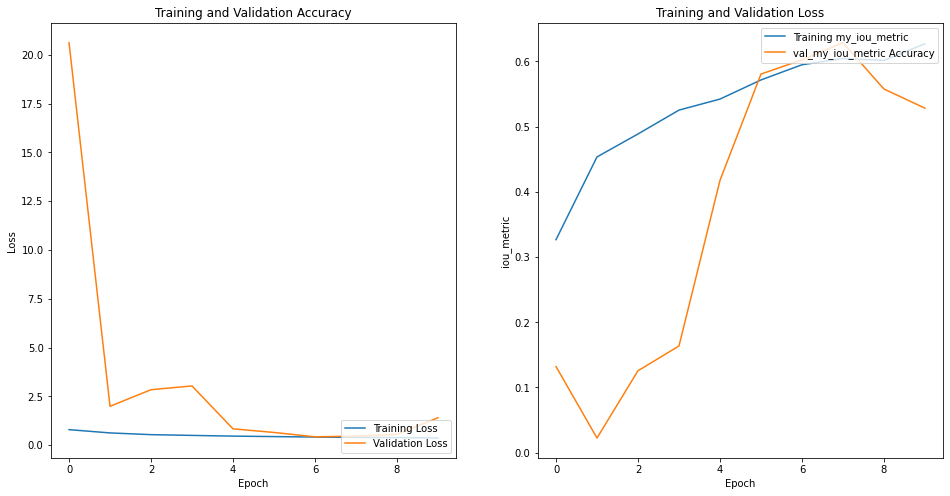

In [62]:
my_iou_metric = history.history['my_iou_metric']
val_my_iou_metric = history.history['val_my_iou_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

res_net_lr = history.history['lr']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, my_iou_metric, label='Training my_iou_metric')
plt.plot(epochs_range, val_my_iou_metric, label='val_my_iou_metric Accuracy')
plt.xlabel("Epoch")
plt.ylabel("iou_metric")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


val_Lossは１Epochあたりで急激に減少し、0.4前後に収束している。  
val_IoUに関して、rasnetは層数が多い為、立ち上がりが遅いが、3Epoch辺りで急上昇し、0.6前後で収束している。

### Validation set prediction and resizing to original size:  
検証セットの予測とオリジナルサイズへのリサイズ。

In [55]:
val_preds = model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization:   
しきい値の最適化。

In [56]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [57]:
# Threshold range, over which optimization is performed
# 0.2～0.9の範囲で0.02刻みで閾値を設定。
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.

# すべてのしきい値について、予測をバイナリ配列に設定します。
# しきい値を超える値は1として扱われ、残りは0として扱われます。
# しきい値をループして、上記のIoU関数に基づいてしきい値のIoUを計算します。
ious = np.array(
    [iou_metric_batch(y_val_true, np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])


100%|██████████| 35/35 [00:57<00:00,  1.63s/it]


In [58]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.5830 at threshold: 0.600


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.567786
std,0.204939,0.014903
min,0.200000,0.530750
25%,0.370000,0.555000
50%,0.540000,0.575125
75%,0.710000,0.578875
max,0.880000,0.583000


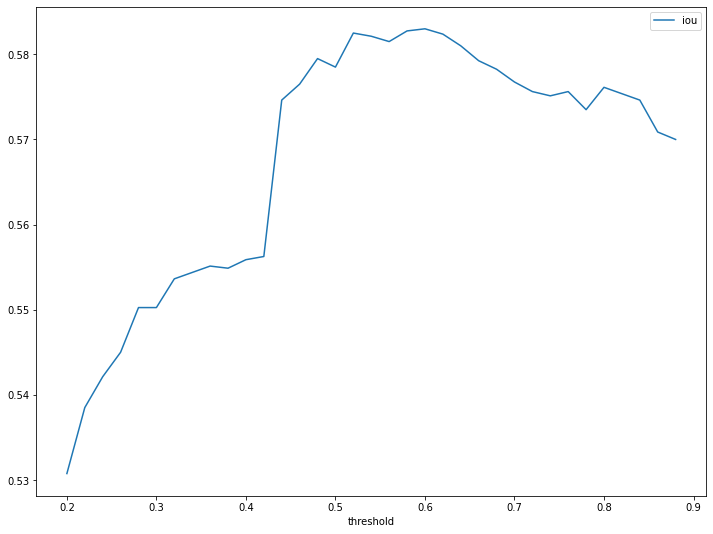

In [64]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')

bestなIoUは、threshold＝0.600の時のIoU＝0.5830

## Conclusions:

- Pretrained models can be used for segmentation problems:
    - Some of architectures can be easily adapted to the problem (ie ResNet)
    - Other architectures may require more experimentation with selection of proper layers for feature extraction and padding (example of using [Xception](https://www.kaggle.com/meaninglesslives/getting-0-87-on-private-lb-using-kaggle-kernel). )
    - You can experiment with selection of layers for feature extraction
    - For some models, you can also try to experiment with number of encoder/decoder blocks
- Threshold optimization is important in problems, where direct metric optimization during training is difficult.
    - It it possible to use more involved optimization methods (from [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)), although this may not be optimal unless distribution of train and test set are very similar. Overoptimization of threshold or any other parameter on validation set may result in worse test set results.
- Experiment with various losses - BCE, Dice, combined BCE with Dice, Lovash loss.
    - Models trained with various losses may give different results, which may be advantageous when ensembling.


### Possible experiments:

- Change type of decoder block in created segmentation model
- Create your own decoder blocks
- Train with other losses
- Train longer
- Train with BCE/Dice, save the model, then load weights and finetune with Lovash loss
- Try different ranges and intervals for threshold optimization

結論：  
●事前学習済みモデルは、セグメンテーションの問題に使用できます。  
　・一部のアーキテクチャは問題に簡単に適応できます（ResNetなど）  

　・他のアーキテクチャでは、特徴抽出とパディングのために適切なレイヤーを選択するための実験がさらに必要になる場合があります  
　　（Xceptionの使用例）  

　・特徴抽出のためのレイヤー選択を試すことができます  
　・一部のモデルでは、エンコーダー/デコーダーブロックの数を試すこともできます  

●しきい値の最適化は、トレーニング中の直接的なメトリックの最適化が難しい問題で重要です。  

　・より複雑な最適化手法（scipy optimizeから）を使用することは可能ですが、トレインとテストセットの分布が非常に類似していない限り、最適化できない可能性があります。検証セットのしきい値やその他のパラメーターを最適化しすぎると、テストセットの結果が悪くなる可能性があります。  

●さまざまな損失の実験-BCE、Dice、BCEとDice、Lovash損失の組み合わせ。  

　・様々な損失で訓練されたモデルは、異なる結果をもたらす可能性があり、それはエンセンブルするときに有利かもしれません。  

可能な実験：  
　●作成したセグメンテーションモデルでデコーダーブロックのタイプを変更  
　●独自のデコーダーブロックを作成  
　●他の損失を伴うトレーニング  
　●学習時間を長く  
　●BCE /ダイスでトレーニングし、モデルを保存してから、ウェイトをロードし、Lovash 損失で微調整します　　
　●しきい値の最適化のためにさまざまな範囲と間隔を試してください　　

In [60]:
np.int32(0.7 > 1)

0

In [61]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric

## 【問題1】コードレビュー

転移学習を使用してセグメンテーションの精度を改善したコードを提示するので、レビューを行ってください。


《視点例》


前回使用した実装とはどのように違うのか
転移学習をどのように行っているか

Sprint19のモデルは、
＜Encoder＞  
Input→  
Conv→Conv→MaxPool  x３回(チャンネル数：64→128→256→512)  
Conv→Conv→DropOut→MaxPool (チャンネル数：→1024)  
＜中間層＞  
Conv→Conv→DropOut→UpConv (チャンネル数：→512)  
＜Decoder＞  
Concat→Conv→Conv→UpConvx３回(チャンネル数：→256→128→64)  
Concat→Conv→Conv→Conv  (チャンネル数：64→2→1)  

また、Encoder層からDecoder層へ4回スキップコネクションにより特徴マップを連結させている

Sprint20のモデルは、  
＜Encoder＞  
ResNet50により50層構造となっている。
＜Decoder＞   
bottleneckアーキテクチャを採用し、計算負荷を増やすことなく多層化し、精度を向上させている。

Encoder層からDecoder層へ4回スキップコネクションにより特徴マップを連結させている

### ★Sprint20の各レイヤーについての詳細については、[補足資料](https://github.com/takatoshi-ii/diveintocode-ml/blob/master/Sprint/Splint20/Sprint20_Detail.pdf)を参照してください。

### 転移学習をどのように行っているか

⇒①以下のコードでimagenetの学習済み重みを呼び出している。
```python
model = unet_resnet(
    input_size, decoder_block_simple, weights='imagenet')
```

Encode部分のResnetとDecode部分の自作モデル間で以下のスキップコネクションを接続している。
Encode　　　　　　　Decode  
conv1　　　　 　⇒　concatenate_5  
res2c_branch2c　⇒　concatenate_4  
res3d_branch2c　⇒　concatenate_3  
res4f_branch2c　⇒　concatenate_2  
res5c_branch2c　⇒　concatenate_1  

## 【問題2】コードの書き換え
エンコーダーにResNetが使用されていたコードをVGGに変更してください。

### Encoder features - VGG19:


- 'block2_conv2', shape: (None, 112, 112, 64)
- 'block3_conv4', shape: (None, 56, 56, 256)
- 'block4_conv4', shape: (None, 28, 28, 512)
- 'block5_conv4', shape: (None, 14, 14, 1024)
- 'block5_pool', shape: (None, 7, 7, 2048)
One thing to keep in mind is that every time a model will be created in the same TF session in the notebook, layer names will change, so above layer names correspond to first creation of the model. In order to reset session, call K.clear_session().

### ★Skip Connectionの詳細については、[補足資料](https://github.com/takatoshi-ii/diveintocode-ml/blob/master/Sprint/Splint20/Sprint20_Detail.pdf)「Encoder部の比較」を参照してください。

In [17]:
# from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg19 import VGG19, preprocess_input
input_size = (224, 224, 3)

base_VGG_model = VGG19(input_shape=input_size, include_top=False)
base_VGG_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

80142336/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 

### Model definition:
Combine encoder and decoder blocks to create final segmentation model.

In [34]:
from keras.applications.vgg19 import VGG19, preprocess_input
# Model is parametrized in a way to enable easy change of decoder_block type,
# as this is an argument that can be given a function, like decoder_block_simple.
def unet_vgg19(input_size, decoder_block,
                weights='imagenet',
                loss_func='binary_crossentropy',
                metrics_list=[my_iou_metric],
                use_lovash=False):

    # Base model - encoder
    base_vgg19_model = VGG19(input_shape=input_size, 
                            include_top=False,
                            weights=weights)
    
    # Layers for feature extraction in the encoder part
    encoder1 = base_vgg19_model.get_layer('block2_conv2').output # activation_1
    encoder2 = base_vgg19_model.get_layer('block3_conv4').output # activation_10
    encoder3 = base_vgg19_model.get_layer('block4_conv4').output # activation_22
    encoder4 = base_vgg19_model.get_layer('block5_conv4').output # activation_40
    encoder5 = base_vgg19_model.get_layer('block5_pool').output # activation_40

    # Center block
    center = decoder_block(encoder5, 'center', num_filters=512)
    concat5 = concatenate([center, encoder5], axis=-1)

    # Decoder part.
    # Every decoder block processed concatenated output from encoder and decoder part.
    # This creates skip connections.
    # Afterwards, decoder output is upsampled to dimensions equal to encoder output part.
    decoder4 = decoder_block(concat5, 'decoder4', num_filters=256)
    concat4 = concatenate([UpSampling2D()(decoder4), encoder4], axis=-1)

    decoder3 = decoder_block(concat4, 'decoder3', num_filters=128)
    concat3 = concatenate([UpSampling2D()(decoder3), encoder3], axis=-1)

    decoder2 = decoder_block(concat3, 'decoder2', num_filters=64)
    concat2 = concatenate([UpSampling2D()(decoder2), encoder2], axis=-1)

    decoder1 = decoder_block(concat2, 'decoder1', num_filters=64)
    concat1 = concatenate([UpSampling2D()(decoder1), encoder1], axis=-1)

    # Final upsampling and decoder block for segmentation.
    output = UpSampling2D()(concat1)
    output = decoder_block(output, 'decoder_output', num_filters=32)
    output = Conv2D(1, (1, 1), activation=None, name='prediction')(output)
    if not use_lovash:
        output = Activation('sigmoid')(output)
        
    model = Model(base_vgg19_model.input, output)
    model.compile(loss=loss_func, optimizer='adam', metrics=metrics_list)

    return model

### Inspect created model:

In [35]:
input_size = (224, 224, 3)


K.clear_session()
model_vgg19 = unet_vgg19(input_size, decoder_block_simple, weights='imagenet')
model_vgg19.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Train model:

In [36]:
K.clear_session()

# Build model:
# Here, you can experiment with various losses.
# For dice and BCE (binary_crossentropy), my_iou_metric should be used,
# whereas for lovash_loss my_iou_metric2 should be used, because range of values
# for lovash loss is between -inf and +inf, not between 0 and 1, as for BCE and dice.
# What is more, when lovash loss is used, last layer (sigmoid) should be deleted.
# This is controlled by use_lovash parameter.
vgg19_model_depth = unet_vgg19(
    input_size, decoder_block_bottleneck, weights='imagenet',
    loss_func=bce_dice_loss, metrics_list=[my_iou_metric],
    use_lovash=False)
print(vgg19_model_depth.summary())


model_checkpoint = ModelCheckpoint(
    'unet_vgg19.h5' ,monitor='val_my_iou_metric', mode='max',
    save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_my_iou_metric',
    mode='max',
    factor=0.5, 
    patience=5, 
    min_lr=0.0001, 
    verbose=1)


epochs = 10  # 25
batch_size = 16

history = vgg19_model_depth.fit(X_tr, y_tr,
                    validation_data=[X_val, y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

Validation set prediction and resizing to original size:

In [38]:
import pickle
with open('/content/drive/My Drive/DIC/Segmantation/vgg19_model_depth.pkl', 'wb') as vgg19_model:
    pickle.dump(vgg19_model_depth, vgg19_model)


In [ ]:
aaaaabbbcccddeeffgghh

In [39]:
val_preds = vgg19_model_depth.predict(X_val, batch_size=16)

y_val_pred = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), val_preds)))
y_val_true = np.asarray(list(map(lambda x: cv2.resize(x, (101, 101)), y_val)))

### Threshold optimization:

In [40]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [41]:
# Threshold range, over which optimization is performed
thresholds = np.arange(0.2, 0.9, 0.02)

# For every threshold, set predictions to binary arrays, 
# where values above threshold are treated as 1 and the rest as 0.
# Loop over thresholds and compute IoU for them based on IoU function above.
ious = np.array(
    [iou_metric_batch(y_val_true,
                      np.int32(y_val_pred > threshold)) for threshold in tqdm(thresholds)])


100%|██████████| 35/35 [00:53<00:00,  1.52s/it]


In [42]:
df_iou = pd.DataFrame(thresholds, columns=['threshold'])
df_iou['iou'] = ious

# Get index of best IoU
best_index = df_iou['iou'].idxmax()
print('Best IoU: {:.4f} at threshold: {:.3f}'.format(
    df_iou.iou[best_index], df_iou.threshold[best_index]))

# Describe IoU DF
df_iou.describe()

Best IoU: 0.6380 at threshold: 0.840


,threshold,iou
count,35.000000,35.000000
mean,0.540000,0.586321
std,0.204939,0.040910
min,0.200000,0.512875
25%,0.370000,0.555813
50%,0.540000,0.588375
75%,0.710000,0.625000
max,0.880000,0.638000


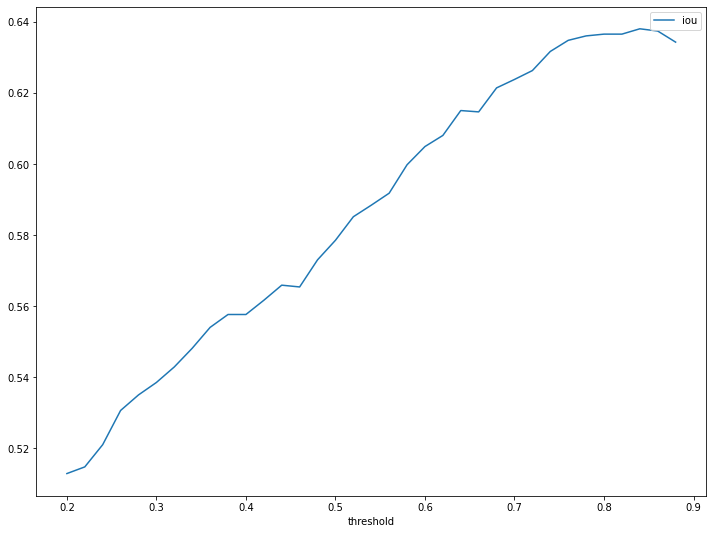

In [43]:
# Plot IoU values over threshold range.
df_iou.plot(x='threshold', y='iou')